# DLS Reading Python Code

# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
import calendar

#from google.colab import drive
#drive.mount('/content/drive')

# Load Data

In [2]:
df = pd.read_excel('/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/AL Data/B3P170 - R18 and CF LUV + LNP/2023-07-27 - DLS/2023-07-27 lnp.xlsx')
df

,Measurement Date and Time,Record Number,Sample Name,Intensities[1] (Percent),Intensities[2] (Percent),Intensities[3] (Percent),Intensities[4] (Percent),Intensities[5] (Percent),Intensities[6] (Percent),Intensities[7] (Percent),...,Numbers[62] (Percent),Numbers[63] (Percent),Numbers[64] (Percent),Numbers[65] (Percent),Numbers[66] (Percent),Numbers[67] (Percent),Numbers[68] (Percent),Numbers[69] (Percent),Numbers[70] (Percent),Diffusion Coefficient (µ²/s)
0,"Thursday, July 27, 2023 8:42:10 PM",1,306oi10 LNP pH 7.4 0.1X 1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.69
1,"Thursday, July 27, 2023 8:44:43 PM",2,306oi10 LNP pH 7.4 0.1X 2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.78
2,"Thursday, July 27, 2023 8:47:16 PM",3,306oi10 LNP pH 7.4 0.1X 3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.79
3,"Friday, July 28, 2023 6:32:18 PM",4,306oi10 LNP pH 7.4 0.1X 1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.76
4,"Friday, July 28, 2023 6:34:41 PM",5,306oi10 LNP pH 7.4 0.1X 2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.82
5,"Friday, July 28, 2023 6:37:04 PM",6,306oi10 LNP pH 7.4 0.1X 3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.82
6,"Monday, July 31, 2023 11:19:00 AM",7,306oi10 LNP pH 7.4 0.1X 1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.83
7,"Monday, July 31, 2023 11:21:33 AM",8,306oi10 LNP pH 7.4 0.1X 2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.85
8,"Monday, July 31, 2023 11:24:07 AM",9,306oi10 LNP pH 7.4 0.1X 3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.83
9,"Monday, July 31, 2023 11:39:53 AM",10,CF POPG LUV 1X 1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.73


## Extract Size Data in `size` df

In [3]:
size = df.filter(regex=r'Size').drop_duplicates().T.reset_index().rename(columns={0:"Diameter (nm)"})
size['DLS index'] = size['index'].str.findall(r'\d+').explode()
size = size.drop(columns='index')
size

,Diameter (nm),DLS index
0,0.4000,1
1,0.4632,2
2,0.5365,3
3,0.6213,4
4,0.7195,5
...,...,...
65,5560.0000,66
66,6439.0000,67
67,7456.0000,68
68,8635.0000,69


## Format sample names and dates in `info` df

In [4]:
info = pd.DataFrame(df.loc[:,['Measurement Date and Time','Sample Name','Record Number']].copy(deep=True))
info['Triplicate'] = info['Sample Name'].str.strip().str[-1]
info['title'] = info['Sample Name'].str.rstrip(r'123 ')

# extract date and time information
info = info.join(pd.DataFrame(info["Measurement Date and Time"].str.findall(r'([A-Z][a-z]*), ([A-Z][a-z]*) (\d\d?), (\d{4}) (\d\d?:\d\d?:\d\d [AP]M)').explode().to_list(), columns=["day of week","month","day","year","time"]))

# replace string month to numerical month to be read by datetime function
d = dict((v,k) for k,v in enumerate(calendar.month_name))
info["month"] = info.month.map(d)

# convert columns to integer datatype
info["day"] = info["day"].astype(int)
info["month"] = info["month"].astype(int)
info["year"] = info["year"].astype(int)

# convert month/day/year into datetime format
info["date"] = pd.to_datetime(info.loc[:,["year","month","day"]])

# remove month/date/year columns
info.drop(columns=['year','month','day','day of week'], inplace=True)

info

,Measurement Date and Time,Sample Name,Record Number,Triplicate,title,time,date
0,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27
1,"Thursday, July 27, 2023 8:44:43 PM",306oi10 LNP pH 7.4 0.1X 2,2,2,306oi10 LNP pH 7.4 0.1X,8:44:43 PM,2023-07-27
2,"Thursday, July 27, 2023 8:47:16 PM",306oi10 LNP pH 7.4 0.1X 3,3,3,306oi10 LNP pH 7.4 0.1X,8:47:16 PM,2023-07-27
3,"Friday, July 28, 2023 6:32:18 PM",306oi10 LNP pH 7.4 0.1X 1,4,1,306oi10 LNP pH 7.4 0.1X,6:32:18 PM,2023-07-28
4,"Friday, July 28, 2023 6:34:41 PM",306oi10 LNP pH 7.4 0.1X 2,5,2,306oi10 LNP pH 7.4 0.1X,6:34:41 PM,2023-07-28
5,"Friday, July 28, 2023 6:37:04 PM",306oi10 LNP pH 7.4 0.1X 3,6,3,306oi10 LNP pH 7.4 0.1X,6:37:04 PM,2023-07-28
6,"Monday, July 31, 2023 11:19:00 AM",306oi10 LNP pH 7.4 0.1X 1,7,1,306oi10 LNP pH 7.4 0.1X,11:19:00 AM,2023-07-31
7,"Monday, July 31, 2023 11:21:33 AM",306oi10 LNP pH 7.4 0.1X 2,8,2,306oi10 LNP pH 7.4 0.1X,11:21:33 AM,2023-07-31
8,"Monday, July 31, 2023 11:24:07 AM",306oi10 LNP pH 7.4 0.1X 3,9,3,306oi10 LNP pH 7.4 0.1X,11:24:07 AM,2023-07-31
9,"Monday, July 31, 2023 11:39:53 AM",CF POPG LUV 1X 1,10,1,CF POPG LUV 1X,11:39:53 AM,2023-07-31


## Find all unique titles and dates in `info`. Save to `samples` dataframe and generate unique sample `id`. 

In [5]:
samples = info.loc[:,["title","date"]].drop_duplicates()

In [6]:
samples["id"] = np.arange(0,samples.shape[0])
samples.head()

,title,date,id
0,306oi10 LNP pH 7.4 0.1X,2023-07-27,0
3,306oi10 LNP pH 7.4 0.1X,2023-07-28,1
6,306oi10 LNP pH 7.4 0.1X,2023-07-31,2
9,CF POPG LUV 1X,2023-07-31,3
12,CF POPC LUV 1X,2023-07-31,4


## Compute days since first sample for each unique title

In [7]:
# new startdate pivot table with earliest date for each unique title
startdate = pd.pivot_table(data=samples,
               index="title",
               values="date",
               aggfunc="min").rename(columns={"date" : "start date"})

In [8]:
# add back in to samples and compute days since 'start date'
samples = samples.merge(startdate, left_on="title",right_on="title")
samples["days since"] = samples["date"] - samples["start date"]
samples["days since"] = samples["days since"].apply(lambda x: x.days)

In [9]:
# return info back to `info` dataframe
info = info.merge(samples, 
           left_on=["title","date"],
           right_on=["title","date"]
          )
info.head()

,Measurement Date and Time,Sample Name,Record Number,Triplicate,title,time,date,id,start date,days since
0,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0
1,"Thursday, July 27, 2023 8:44:43 PM",306oi10 LNP pH 7.4 0.1X 2,2,2,306oi10 LNP pH 7.4 0.1X,8:44:43 PM,2023-07-27,0,2023-07-27,0
2,"Thursday, July 27, 2023 8:47:16 PM",306oi10 LNP pH 7.4 0.1X 3,3,3,306oi10 LNP pH 7.4 0.1X,8:47:16 PM,2023-07-27,0,2023-07-27,0
3,"Friday, July 28, 2023 6:32:18 PM",306oi10 LNP pH 7.4 0.1X 1,4,1,306oi10 LNP pH 7.4 0.1X,6:32:18 PM,2023-07-28,1,2023-07-27,1
4,"Friday, July 28, 2023 6:34:41 PM",306oi10 LNP pH 7.4 0.1X 2,5,2,306oi10 LNP pH 7.4 0.1X,6:34:41 PM,2023-07-28,1,2023-07-27,1


## Create intensity dataframe

In [10]:
intensity = df.filter(regex=r'Record Number|Intensities').set_index('Record Number').T
intensity['DLS index'] = pd.Series(intensity.index).str.findall(r'\d+').explode().values
intensity

Record Number,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,DLS index
Intensities[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Intensities[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Intensities[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
Intensities[4] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
Intensities[5] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Intensities[66] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66
Intensities[67] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67
Intensities[68] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68
Intensities[69] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69


## Create number dataframe

In [11]:
number = df.filter(regex=r'Record Number|Numbers').set_index('Record Number').T
number['DLS index'] = pd.Series(number.index).str.findall(r'\d+').explode().values
number

Record Number,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,DLS index
Numbers[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Numbers[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Numbers[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
Numbers[4] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
Numbers[5] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Numbers[66] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66
Numbers[67] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67
Numbers[68] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68
Numbers[69] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69


## Join `intensity`, `number`, `size`, and `info` to `df_main`

In [12]:
df_main = intensity.melt(id_vars='DLS index', value_vars=intensity.columns, value_name='Intensity %')

df_main

,DLS index,Record Number,Intensity %
0,1,1,0.0
1,2,1,0.0
2,3,1,0.0
3,4,1,0.0
4,5,1,0.0
...,...,...,...
1465,66,21,0.0
1466,67,21,0.0
1467,68,21,0.0
1468,69,21,0.0


In [13]:
df_main = df_main.join(number.melt(id_vars='DLS index', value_vars=number.columns, value_name='Number %').loc[:,"Number %"])
df_main

,DLS index,Record Number,Intensity %,Number %
0,1,1,0.0,0.0
1,2,1,0.0,0.0
2,3,1,0.0,0.0
3,4,1,0.0,0.0
4,5,1,0.0,0.0
...,...,...,...,...
1465,66,21,0.0,0.0
1466,67,21,0.0,0.0
1467,68,21,0.0,0.0
1468,69,21,0.0,0.0


In [14]:
df_main = df_main.merge(size, left_on="DLS index", right_on="DLS index")
df_main

,DLS index,Record Number,Intensity %,Number %,Diameter (nm)
0,1,1,0.0,0.0,0.4
1,1,2,0.0,0.0,0.4
2,1,3,0.0,0.0,0.4
3,1,4,0.0,0.0,0.4
4,1,5,0.0,0.0,0.4
...,...,...,...,...,...
1465,70,17,0.0,0.0,10000.0
1466,70,18,0.0,0.0,10000.0
1467,70,19,0.0,0.0,10000.0
1468,70,20,0.0,0.0,10000.0


In [15]:
df_main = df_main.merge(info, left_on="Record Number", right_on="Record Number")
df_main

,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Measurement Date and Time,Sample Name,Triplicate,title,time,date,id,start date,days since
0,1,1,0.0,0.0,0.4000,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0
1,2,1,0.0,0.0,0.4632,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0
2,3,1,0.0,0.0,0.5365,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0
3,4,1,0.0,0.0,0.6213,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0
4,5,1,0.0,0.0,0.7195,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,66,21,0.0,0.0,5560.0000,"Monday, July 31, 2023 12:51:32 PM",R18 POPG LUV pH 7.4 0.025X 3,3,R18 POPG LUV pH 7.4 0.025X,12:51:32 PM,2023-07-31,6,2023-07-31,0
1466,67,21,0.0,0.0,6439.0000,"Monday, July 31, 2023 12:51:32 PM",R18 POPG LUV pH 7.4 0.025X 3,3,R18 POPG LUV pH 7.4 0.025X,12:51:32 PM,2023-07-31,6,2023-07-31,0
1467,68,21,0.0,0.0,7456.0000,"Monday, July 31, 2023 12:51:32 PM",R18 POPG LUV pH 7.4 0.025X 3,3,R18 POPG LUV pH 7.4 0.025X,12:51:32 PM,2023-07-31,6,2023-07-31,0
1468,69,21,0.0,0.0,8635.0000,"Monday, July 31, 2023 12:51:32 PM",R18 POPG LUV pH 7.4 0.025X 3,3,R18 POPG LUV pH 7.4 0.025X,12:51:32 PM,2023-07-31,6,2023-07-31,0


# Plot DLS Data

## Plot by `id`

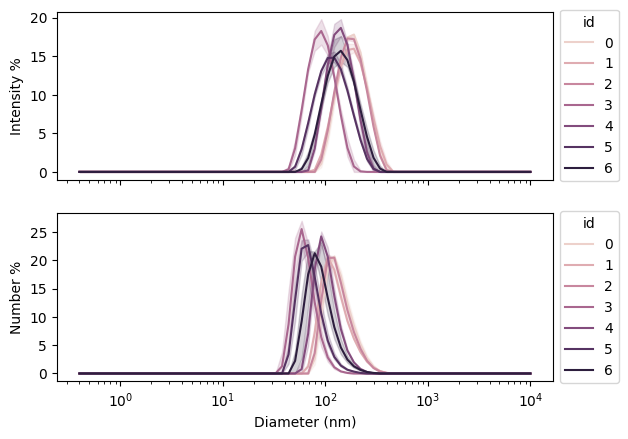

In [16]:
fig, ax = plt.subplots(2,1, sharex=True)

sns.lineplot(data=df_main,
             x="Diameter (nm)",
             y="Intensity %",
             hue="id",
             ax=ax[0])

sns.lineplot(data=df_main,
             x="Diameter (nm)",
             y="Number %",
             hue="id",
             ax=ax[1])

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="id")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="id")

ax[0].set_xscale('log')

# Compute Peak Diameter (mode) for each `id` 

In [17]:
# aggfunc finds the index of the maximum value for intensity and number columns, then uses index to find the diameter at which the max is found
df_pivot = pd.pivot_table(data=df_main,
               index='id',
               values = ["Intensity %","Number %"],
               aggfunc = [lambda x: df_main.loc[x.idxmax(0),"Diameter (nm)"]]
              )

# format column names
df_pivot.columns = ["Peak Diameter by " + a[1] for a in df_pivot.columns.to_flat_index()]

df_pivot

,Peak Diameter by Intensity %,Peak Diameter by Number %
id,,
0,190.10,122.40
1,164.20,105.70
2,164.20,105.70
3,91.28,58.77
4,141.80,91.28
5,122.40,68.06
6,141.80,91.28


In [18]:
# merge back in to df_main
df_main = df_main.merge(df_pivot, left_on="id", right_on="id")
df_main

,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Measurement Date and Time,Sample Name,Triplicate,title,time,date,id,start date,days since,Peak Diameter by Intensity %,Peak Diameter by Number %
0,1,1,0.0,0.0,0.4000,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0,190.1,122.40
1,2,1,0.0,0.0,0.4632,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0,190.1,122.40
2,3,1,0.0,0.0,0.5365,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0,190.1,122.40
3,4,1,0.0,0.0,0.6213,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0,190.1,122.40
4,5,1,0.0,0.0,0.7195,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,8:42:10 PM,2023-07-27,0,2023-07-27,0,190.1,122.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,66,21,0.0,0.0,5560.0000,"Monday, July 31, 2023 12:51:32 PM",R18 POPG LUV pH 7.4 0.025X 3,3,R18 POPG LUV pH 7.4 0.025X,12:51:32 PM,2023-07-31,6,2023-07-31,0,141.8,91.28
1466,67,21,0.0,0.0,6439.0000,"Monday, July 31, 2023 12:51:32 PM",R18 POPG LUV pH 7.4 0.025X 3,3,R18 POPG LUV pH 7.4 0.025X,12:51:32 PM,2023-07-31,6,2023-07-31,0,141.8,91.28
1467,68,21,0.0,0.0,7456.0000,"Monday, July 31, 2023 12:51:32 PM",R18 POPG LUV pH 7.4 0.025X 3,3,R18 POPG LUV pH 7.4 0.025X,12:51:32 PM,2023-07-31,6,2023-07-31,0,141.8,91.28
1468,69,21,0.0,0.0,8635.0000,"Monday, July 31, 2023 12:51:32 PM",R18 POPG LUV pH 7.4 0.025X 3,3,R18 POPG LUV pH 7.4 0.025X,12:51:32 PM,2023-07-31,6,2023-07-31,0,141.8,91.28


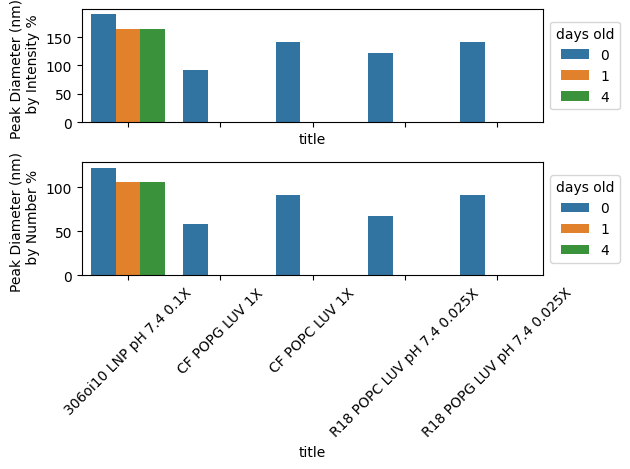

In [19]:
fig, ax = plt.subplots(2, sharex=True)

# plot peak diameter by intensity
sns.barplot(data=df_main,
            x="title",
            y="Peak Diameter by Intensity %",
            hue="days since",
           ax=ax[0])

ax[0].set_ylabel('Peak Diameter (nm) \n by Intensity %')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

# plot peak diameter by number
sns.barplot(data=df_main,
            x="title",
            y="Peak Diameter by Number %",
            hue="days since",
            ax=ax[1])

ax[1].set_ylabel('Peak Diameter (nm) \n by Number %')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

plt.xticks(rotation = 45)

plt.tight_layout()

# Compute z-average

In [20]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %',
       'Diameter (nm)', 'Measurement Date and Time', 'Sample Name',
       'Triplicate', 'title', 'time', 'date', 'id', 'start date', 'days since',
       'Peak Diameter by Intensity %', 'Peak Diameter by Number %'],
      dtype='object')